In [46]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import dipy.data as dpd
import dipy.core.sphere as dps 
import dipy.sims as sims
import dipy.core.gradients as grad
import dipy.core.geometry as geo
import nibabel as nib


import scm.utils as ut
import scm.scm as scm

In [47]:
# 65 direction DTI data
fdata, fbval, fbvec = dpd.get_data()
gtab = grad.gradient_table(fbval, fbvec)
gtab.bvals = gtab.bvals # Make the units work out
data_ni = nib.load(fdata)
data = data_ni.get_data()

In [48]:
ni, gtab = dpd.read_stanford_hardi()

In [49]:
data = ni.get_data()

In [50]:
n_split = 75

In [51]:
data_train = np.concatenate([data[..., :5], data[..., 10:85]], -1)
data_test = np.concatenate([data[..., 5:10], data[..., 85:]], -1)

In [52]:
data_train.shape, data_test.shape

((81, 106, 76, 80), (81, 106, 76, 80))

In [53]:
gtab_train = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[:5], gtab.bvals[10:85]]), 
                                                  np.concatenate([gtab.bvecs[:5], gtab.bvecs[10:85]]))

gtab_test = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[5:10], gtab.bvals[85:]]), 
                                                 np.concatenate([gtab.bvecs[5:10], gtab.bvecs[85:]]))


In [54]:
sph1 = dpd.get_sphere()
#sph1 = dps.Sphere(xyz=[[1,0,0], [0,1,0], [0,0,1]])

In [55]:
dm_train = ut.design_matrix(gtab_train, sph1)

In [56]:
len(dm_train)

2025

In [57]:
alpha = 0.0001
l1_ratio = 0.8

In [58]:
reload(ut)

<module 'scm.utils' from '/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/scm/utils.pyc'>

In [59]:
dist_weights = ut.signal_weights(gtab_train) 
pp_sig = ut.preprocess_signal(data_train, gtab_train, 40, 40, 40, dist_weights=dist_weights)
sq_weights = dist_weights**2

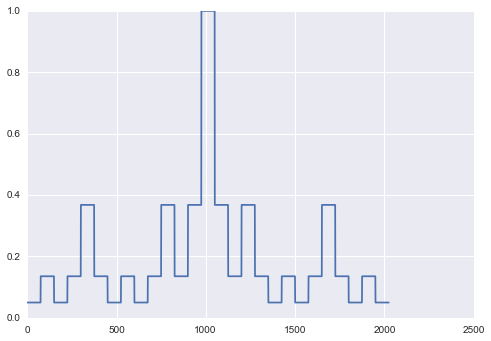

In [60]:
plt.plot(dist_weights)

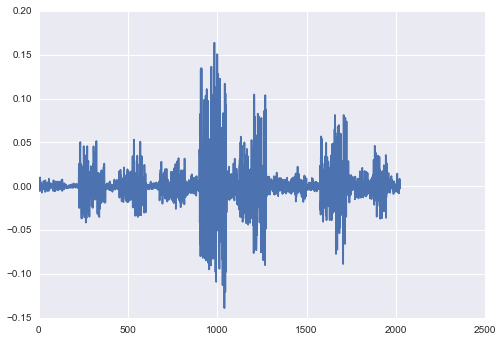

In [61]:
plt.plot(pp_sig)

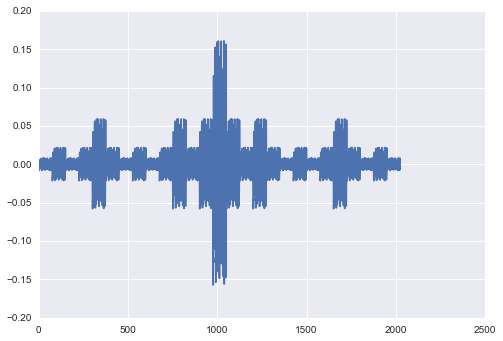

In [62]:
plt.plot(dm_train[:, 0])

In [63]:
pp_sig.shape

(2025,)

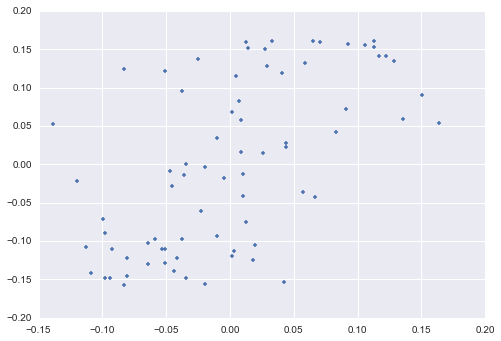

In [64]:
plt.plot(pp_sig[n_split*13:n_split*14], dm_train[n_split*13:n_split*14, 0], '.')

In [65]:
new_dm = dm_train
new_sig = pp_sig

In [66]:
X = new_dm[n_split*13:n_split*14]
X_prime = new_dm[n_split*14:n_split*15]

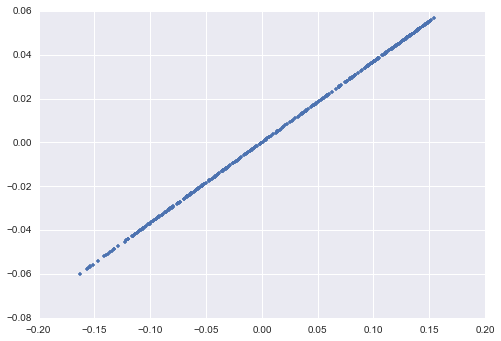

In [67]:
plt.plot(X[0], X_prime[0], '.')

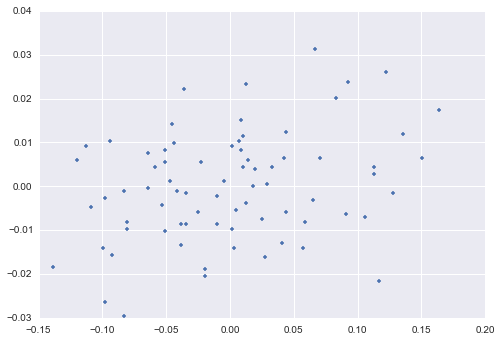

In [68]:
plt.plot(new_sig[n_split*13:n_split*14], new_sig[n_split*14:n_split*15], '.')

In [69]:
from sklearn.linear_model import ElasticNet

In [70]:
this_alpha = alpha * np.sum(sq_weights)/new_dm.shape[0]
EN = ElasticNet(alpha=this_alpha, l1_ratio=l1_ratio, positive=True)
beta = EN.fit(new_dm, new_sig).coef_
#beta, rnorm = opt.nnls(new_dm, new_sig)

In [71]:
new_dm.shape, new_sig.shape

((2025, 362), (2025,))

In [72]:
y_hat = np.dot(new_dm, beta)

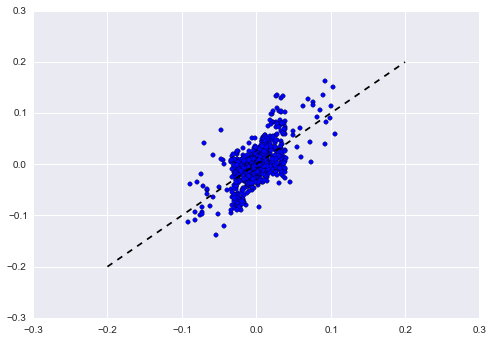

In [73]:
plt.scatter(y_hat, new_sig)
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

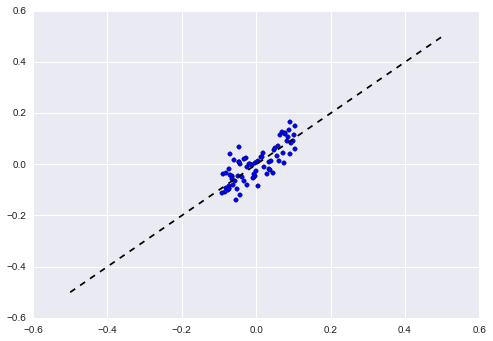

In [74]:
plt.scatter(y_hat[n_split*13:n_split*14], new_sig[n_split*13:n_split*14])
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

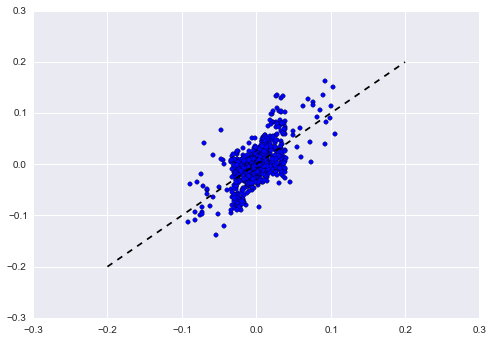

In [75]:
plt.scatter(y_hat[n_split:], new_sig[n_split:])
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

In [76]:
EN = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True)
beta_non = EN.fit(new_dm[n_split*13:n_split*14], new_sig[n_split*13:n_split*14]).coef_

In [77]:
y_hat_non = np.dot(new_dm, beta_non)

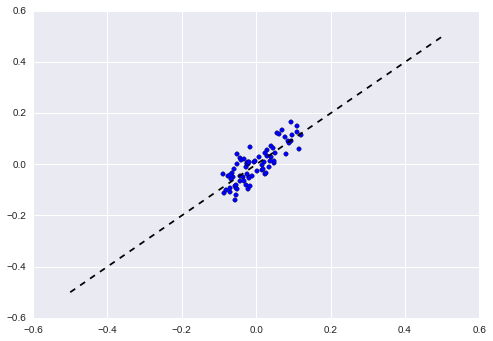

In [78]:
plt.scatter(y_hat_non[n_split*13:n_split*14], new_sig[n_split*13:n_split*14])
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

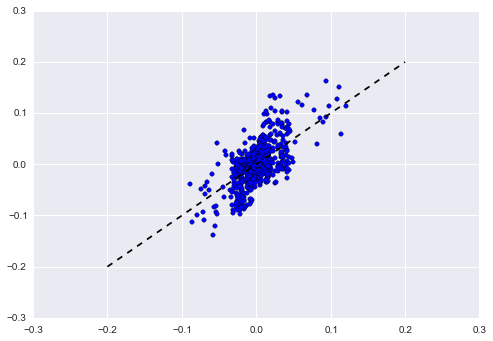

In [79]:
plt.scatter(y_hat_non[n_split:], new_sig[n_split:])
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

1.28338266651
0.909722101049


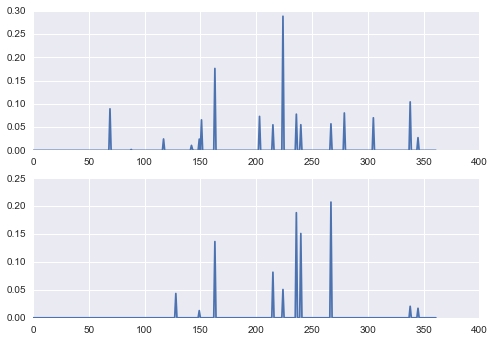

In [80]:
fig, ax = plt.subplots(2)
ax[0].plot(beta_non)
ax[1].plot(beta)
print(np.sum(beta_non))
print(np.sum(beta))

In [81]:
import dipy.viz.projections as proj
reload(proj)

<module 'dipy.viz.projections' from '/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/dipy/viz/projections.pyc'>

In [82]:
%matplotlib inline

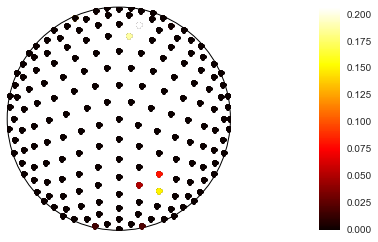

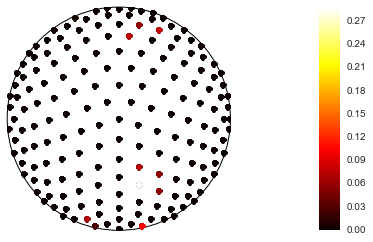

In [83]:
proj.sph_project(sph1.vertices.T, beta) 
proj.sph_project(sph1.vertices.T, beta_non) 

In [84]:
(np.sqrt(np.mean( (y_hat_non[n_split*13:n_split*14]- new_sig[n_split*13:n_split*14]) ** 2))/
np.sqrt(np.mean( (new_sig[n_split*13:n_split*14] - y_hat[n_split*13:n_split*14])**2 ) ))

0.91458968973012522

In [85]:
dm_test = ut.design_matrix(gtab_test, sph1)

In [86]:
y_hat_test = np.dot(dm_test, beta)
y_hat_non_test = np.dot(dm_test, beta_non)

In [87]:
dist_weights = ut.signal_weights(gtab_test) 
sig_test = ut.preprocess_signal(data_test, gtab_test, 40, 40, 40, dist_weights=dist_weights)
sq_weights = dist_weights**2

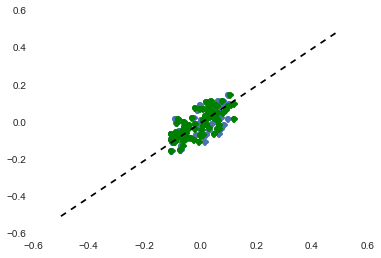

In [88]:
plt.plot(y_hat_test[n_split*13:n_split*14], sig_test[n_split*13:n_split*14], 'o')
plt.plot(y_hat_non_test[n_split*13:n_split*14], sig_test[n_split*13:n_split*14], 'go')
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

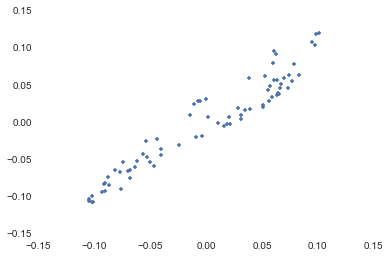

In [89]:
plt.plot(y_hat_test[n_split*13:n_split*14], y_hat_non_test[n_split*13:n_split*14], '.')

In [90]:
(np.sqrt(np.mean( (y_hat_non_test[n_split*13:n_split*14]- sig_test[n_split*13:n_split*14]) ** 2))/
np.sqrt(np.mean((sig_test[n_split*13:n_split*14] - y_hat_test[n_split*13:n_split*14])**2 )))

0.96152075810680393